In [ ]:
import torch, cv2, os, argparse, sys
import numpy as np
from torchsummary import summary
from torch.autograd import Function
from torch.nn import functional as F
from torchvision import models
import matplotlib.pyplot as plt
from utils import ClassDef

class Resnet():
    def __init__(self, model, layers, sub_layers):
        self.model = model
        self.layers = layers
        self.sub_layers = sub_layers
        self.gradient = []

    def save_gradient(self, grad):
        self.gradient.append(grad)

    def get_gradient(self):
        return self.gradient

    def __call__(self, x):
        self.gradient = []
        for idx, module in self.model.named_children():
            x = module(x)
            if idx == 'avgpool':
                x = torch.flatten(x,1)
            if idx in self.layers:
                for sub_idx, sub_module in module[len(module)-1].named_children():
                    if sub_idx in self.sub_layers:
                        x.register_hook(self.save_gradient) #
                        feature_maps = x
        return feature_maps, x
    
class GradCam:
    def __init__(self, model, layers, sub_layers):
        self.model = model
        self.model.eval()
        self.extractor = Resnet(self.model, layers, sub_layers)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):

        features, output = self.extractor(input)
        probs, idx = 0, 0
        if index == None:
            index = np.argmax(output.cpu().data.numpy())
            h_x = F.softmax(output,dim=1).data.squeeze()
            probs, idx = h_x.sort(0,True)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        
        one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradient()[-1].cpu().data.numpy()

        target = features

        target_cam = target.cpu().data.numpy()
        bz, nc, h,w = target_cam.shape

        target = target.cpu().data.numpy()[0, :]

        params = list(self.model.parameters())

        weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

        cam = weight_softmax[index].dot(target_cam.reshape((nc,h*w)))
        cam = cam.reshape(h,w)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224)) 
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        weights = np.mean(grads_val, axis=(2, 3))[0, :] 
        grad_cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            grad_cam += w * target[i, :, :]

        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = cv2.resize(grad_cam, (224, 224))
        grad_cam = grad_cam - np.min(grad_cam)
        grad_cam = grad_cam / np.max(grad_cam)
        
        return grad_cam, cam, index, probs, idx,
    
class FeatureExtractor():

    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.gradient = []

    def save_gradient(self, grad):
        self.gradient.append(grad)
        
    def get_gradient(self):
        return self.gradient

    def __call__(self, x):
        self.gradient = []
        for idx, module in self.model._modules.items():
            x = module(x)
            if idx in self.layers:
                x.register_hook(self.save_gradient)
                feature_maps = x 
        return feature_maps, x


class vgg():
    def __init__(self, model, layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, layers)

    def get_gradient(self):
        return self.feature_extractor.gradient

    def __call__(self, x):
        activation, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return activation, output

class VggGradCam:
    def __init__(self, model, layers):
        self.model = model
        self.model.eval()
        self.extractor = vgg(self.model, layers)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        features, output = self.extractor(input)
        probs, idx = 0,0
        if index == None:
            index = np.argmax(output.cpu().data.numpy())  # index = 정답이라고 추측한 class index
            h_x = F.softmax(output,dim=1).data.squeeze()
            probs, idx = h_x.sort(0,True)
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradient()[-1].cpu().data.numpy()
        
        target = features  # A^k
        target = target.cpu().data.numpy()[0, :]

        cam = None

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        grad_cam = np.zeros(target.shape[1:], dtype=np.float32)  # 14X14

        for i, w in enumerate(weights):
            grad_cam += w * target[i, :, :] 

        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = cv2.resize(grad_cam, (224, 224))
        grad_cam = grad_cam - np.min(grad_cam)
        grad_cam = grad_cam / np.max(grad_cam)
        return grad_cam, cam, index, probs, idx,
    
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

def deprocess_image(img):
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

def VisualizeCam(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    
    return np.uint8(255*cam)

class Backpropagation:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * output)

        one_hot.backward(retain_graph=True)
        output = input.grad.cpu().data.numpy()
        print(output.shape)
        output = output[0, :, :, :]

        return output
    
class GuidedBackpropagation(Function):
    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)

        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)

        return output


    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)

        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input), torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output, positive_mask_1), positive_mask_2)
        
        return grad_input


class GuidedBackpropagation_resnet:
    def __init__(self, model):
        self.model = model
        self.model.eval()

        for idx, module in self.model._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model._modules[idx] = GuidedBackpropagation.apply
                
            if module.__class__.__name__ == 'Sequential':
                for block_idx, block_module in module._modules.items():
                    for block_sub_idx , block_sub_module in block_module._modules.items():
                        if block_sub_module.__class__.__name__ == 'ReLU':
                            self.model._modules[idx][int(block_idx)]._modules[block_sub_idx] = GuidedBackpropagation.apply


    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):

        output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * output)

        one_hot.backward(retain_graph=True)
        output = input.grad.cpu().data.numpy()
        print(output.shape)
        output = output[0, :, :, :]

        return output


class GuidedBackpropagation_vgg:
    def __init__(self, model):
        self.model = model
        self.model.eval()

        for idx, module in self.model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                self.model.features._modules[idx] = GuidedBackpropagation.apply

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot * output)

        one_hot.backward(retain_graph=True)
        output = input.grad.cpu().data.numpy()
        print(output.shape)
        output = output[0, :, :, :]

        return output

1 : VGG19 / 2 : ResNet18 / 3 : ResNet34 
Input the number:  2


Model: ResNet18
-------------------------------------------------
Top 1: pug, pug-dog 0.728
Top 2: bull mastiff 0.229
Top 3: French bulldog 0.018
Top 4: boxer 0.007
Top 5: Brabancon griffon 0.003
-------------------------------------------------
Final Prediction :  pug, pug-dog
(1, 3, 224, 224)
(1, 3, 224, 224)


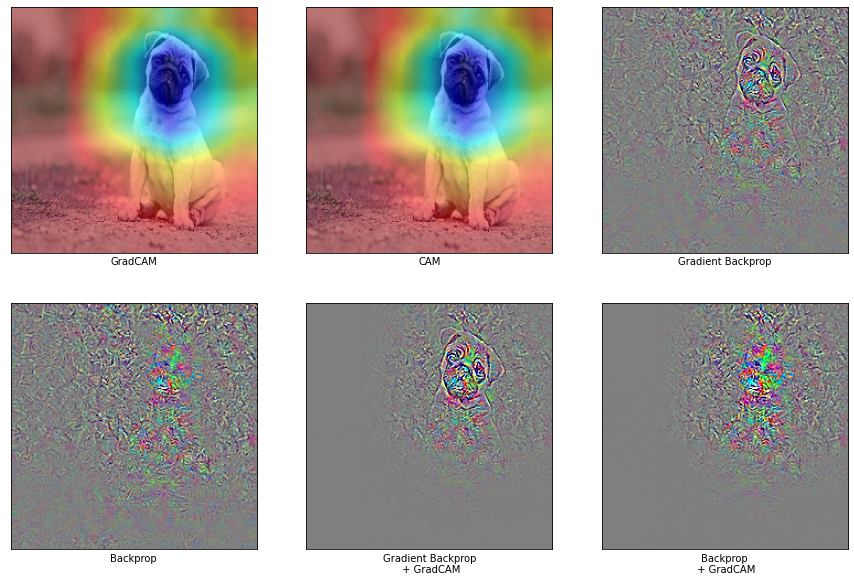

In [3]:
model_name = {1:'VGG19',2:'ResNet18',3:'ResNet34'}

sys.argv=['']

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--image-path', type=str, default='./images/base_dog.jpg', help='Input image path')
    args = parser.parse_args()

    return args


if __name__ == '__main__':
    for i in range(1,4):
        os.makedirs("Result_{}".format(model_name[i]),exist_ok=True)
    select_num = int(input('1 : VGG19 / 2 : ResNet18 / 3 : ResNet34 \nInput the number: '))
    args = get_args()
    final_layer = 'layer4'

    img = cv2.imread(args.image_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input = preprocess_image(img)

    target_index = None

    gradient = []
    features = []
    print("Model: {}".format(model_name[select_num]))
    if select_num == 1:
        model1 = models.vgg19(pretrained=True)
        model2 = models.vgg19(pretrained=True)
        model3 = models.vgg19(pretrained=True)
        grad_cam = VggGradCam(model=model1,layers=["35"])
        bp_model = Backpropagation(model=model2)
        gb_model = GuidedBackpropagation_vgg(model=model3)
    elif select_num == 2:
        model1 = models.resnet18(pretrained=True)
        model2 = models.resnet18(pretrained=True)
        model3 = models.resnet18(pretrained=True)
        grad_cam = GradCam(model=model1,layers=[final_layer],sub_layers=["conv2"])
        bp_model = Backpropagation(model=model2)
        gb_model = GuidedBackpropagation_resnet(model=model3)
    elif select_num ==3:
        model1 = models.resnet34(pretrained=True)
        model2 = models.resnet34(pretrained=True)
        model3 = models.resnet34(pretrained=True)
        grad_cam = GradCam(model=model1,layers=[final_layer],sub_layers=["conv2"])
        bp_model = Backpropagation(model=model2)
        gb_model = GuidedBackpropagation_resnet(model=model3)
    mask_gradcam, mask_cam,index, probs, idx = grad_cam(input, target_index)

    print('-------------------------------------------------')
    if target_index==None:
        for i in range(0, 5):
            line = 'Top {}: {} {:.3f}'.format(i+1, ClassDef.ImageNet_classes[idx[i].item()], probs[i])
            print(line)
    print('-------------------------------------------------')
    print("Final Prediction : ", ClassDef.ImageNet_classes[index])

    save_heatmap_gradcam = VisualizeCam(img, mask_gradcam)
    if select_num >= 2 and select_num <=3:
        save_heatmap_cam= VisualizeCam(img,mask_cam)
    cam_mask = cv2.merge([mask_gradcam, mask_gradcam, mask_gradcam])

    bp = bp_model(input, index=target_index)
    bp = bp.transpose((1, 2, 0))
    cam_bp = deprocess_image(cam_mask * bp)
    bp = deprocess_image(bp)

    gb = gb_model(input, index=target_index)
    gb = gb.transpose((1, 2, 0))
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    fig = plt.figure(figsize=(15, 10))
    rows = 2
    cols = 3
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(save_heatmap_gradcam)
    ax1.set_xlabel("GradCAM")
    ax1.set_xticks([]), ax1.set_yticks([])
    if select_num >= 2 and select_num <=3:
        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(save_heatmap_cam)
        ax2.set_xlabel("CAM")
        ax2.set_xticks([]), ax2.set_yticks([])
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(gb)
    ax3.set_xlabel("Gradient Backprop")
    ax3.set_xticks([]), ax3.set_yticks([])
    ax4 = fig.add_subplot(rows, cols, 4)
    ax4.imshow(bp)
    ax4.set_xlabel("Backprop")
    ax4.set_xticks([]), ax4.set_yticks([])
    ax5 = fig.add_subplot(rows, cols, 5)
    ax5.imshow(cam_gb)
    ax5.set_xlabel("Gradient Backprop\n + GradCAM")
    ax5.set_xticks([]), ax5.set_yticks([])
    ax6 = fig.add_subplot(rows, cols, 6)
    ax6.imshow(cam_bp)
    ax6.set_xlabel("Backprop\n + GradCAM")
    ax6.set_xticks([]), ax6.set_yticks([])
    plt.show()